In [1]:
import os, sys
sys.path.append("/content")
from src.utils import fit_mlp, plot_obs_predict

with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}


In [2]:
# Specify hyperparameters and fit model
buffer_distance = 500
day_tolerance = 8
cloud_thr = 80
min_water_pixels = 10
features = [
    "Intercept", "sentinel-2-l2a_AOT", 
    "sentinel-2-l2a_B02", "sentinel-2-l2a_B03", "sentinel-2-l2a_B04", # RGB bands
    "sentinel-2-l2a_B08", # NIR
    #"sentinel-2-l2a_WVP", 
    "sentinel-2-l2a_B05", "sentinel-2-l2a_B06", "sentinel-2-l2a_B07", "sentinel-2-l2a_B8A",  # Red edge bands
    "is_brazil", #"sine_julian", 
    "sentinel-2-l2a_B11", "sentinel-2-l2a_B12", # SWIR
    "mean_viewing_azimuth", "mean_viewing_zenith",
    "mean_solar_azimuth", "mean_solar_zenith"
]
epochs = 1000
batch_size = 32
learning_rate = 0.005

layer_out_neurons = [12, 24, 6]
n_layers = len(layer_out_neurons)

model_out = fit_mlp(
    features,
    learning_rate,
    batch_size,
    epochs,
    storage_options,
    buffer_distance=buffer_distance,
    day_tolerance=day_tolerance,
    cloud_thr=cloud_thr,
    mask_method1="lulc",
    mask_method2="mndwi",
    min_water_pixels=min_water_pixels,
    layer_out_neurons=layer_out_neurons
)

Begin training.
Epoch 10/1000 | Train Loss: 0.62388 | Val Loss: 0.54313
Epoch 20/1000 | Train Loss: 0.52209 | Val Loss: 0.44766
Epoch 30/1000 | Train Loss: 0.49230 | Val Loss: 0.42752
Epoch 40/1000 | Train Loss: 0.47204 | Val Loss: 0.41038
Epoch 50/1000 | Train Loss: 0.45057 | Val Loss: 0.40705
Epoch 60/1000 | Train Loss: 0.44528 | Val Loss: 0.39597
Epoch 70/1000 | Train Loss: 0.47519 | Val Loss: 0.43428
Epoch 80/1000 | Train Loss: 0.44009 | Val Loss: 0.48400
Epoch 90/1000 | Train Loss: 0.40444 | Val Loss: 0.41246
Epoch 100/1000 | Train Loss: 0.36245 | Val Loss: 0.40279
Epoch 110/1000 | Train Loss: 0.35300 | Val Loss: 0.37792
Epoch 120/1000 | Train Loss: 0.32391 | Val Loss: 0.38176
Epoch 130/1000 | Train Loss: 0.30217 | Val Loss: 0.36974
Epoch 140/1000 | Train Loss: 0.28744 | Val Loss: 0.35001
Epoch 150/1000 | Train Loss: 0.29442 | Val Loss: 0.37853
Epoch 160/1000 | Train Loss: 0.28788 | Val Loss: 0.34493
Epoch 170/1000 | Train Loss: 0.31637 | Val Loss: 0.38143
Epoch 180/1000 | Train L

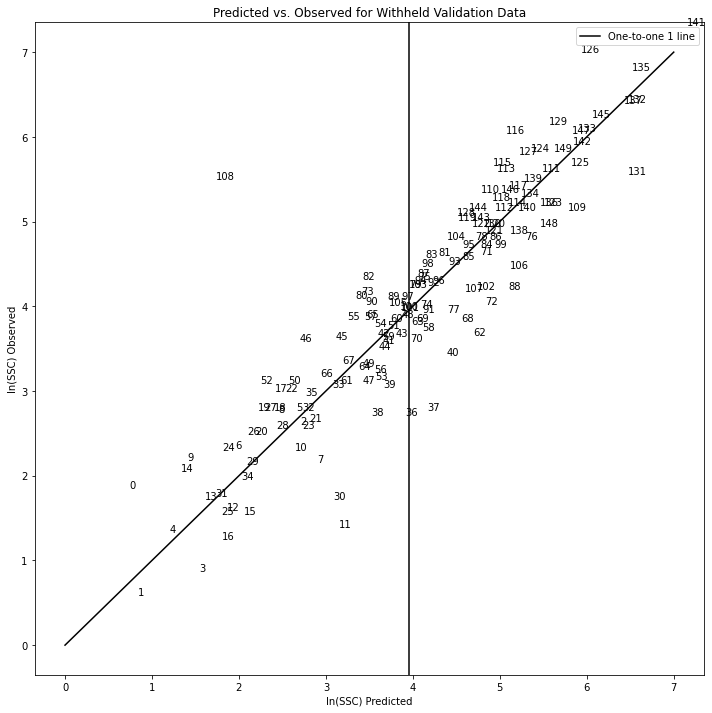

In [3]:
# Plot observed vs predicted for Test data
from matplotlib import pyplot as plt
import numpy as np
def plot_obs_predict(obs_pred, title, savefig=False, outfn=""):
    plt.figure(figsize=(12,12))
    plt.plot(list(range(0,8)),list(range(0,8)), color="black", label="One-to-one 1 line")
    #plt.scatter(obs_pred.iloc[:,0], obs_pred.iloc[:,1])
    plt.axvline(x=np.mean(obs_pred.iloc[:,1]), color="black")
    plt.xlabel("ln(SSC) Predicted")
    plt.ylabel("ln(SSC) Observed")

    for i, row in obs_pred.iterrows():
        label = f"{i}"

        plt.annotate(label, # this is the text
                    (row[0],row[1]), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,0) # distance from text to points (x,y))
        )
    plt.title(title)
    plt.legend()
    if savefig:
        plt.savefig(
            outfn,
            bbox_inches="tight",
            facecolor="#FFFFFF",
            dpi=150
        )

plot_obs_predict(
    model_out["val_obs_predict"],
    title="Predicted vs. Observed for Withheld Validation Data",
    savefig=False)

https://fluviusdata.blob.core.windows.net/modeling-data/chips/qa/cir_500m_cloudthr80_lulcmndwi_masking/ana_22050001_00000031_2019-04-03.png
(196, 100)


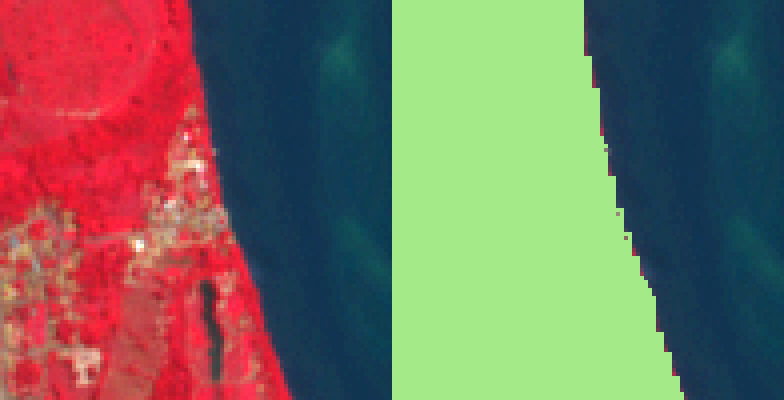

In [23]:
# Visualize observations based on the plot labels above
import fsspec
from PIL import Image
observation_href = model_out["validate"].iloc[108,:]["cir_and_water_png_href"]
print(observation_href)
fs = fsspec.filesystem("az", **storage_options)

with fs.open(observation_href.split(".net/")[1], "rb") as f:
    image = Image.open(f)
    print(image.size)
    image.resize((image.size[0] * 4, image.size[1] * 4), Image.NEAREST).show()

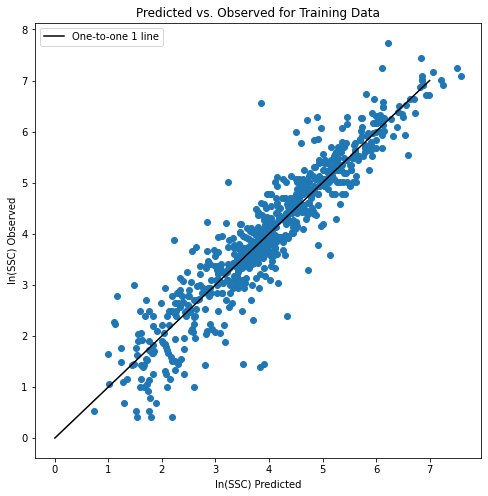

In [4]:
# Plot observed vs predicted for Train data
plot_obs_predict(
    model_out["train_obs_predict"],
    title="Predicted vs. Observed for Training Data",
    savefig=False)

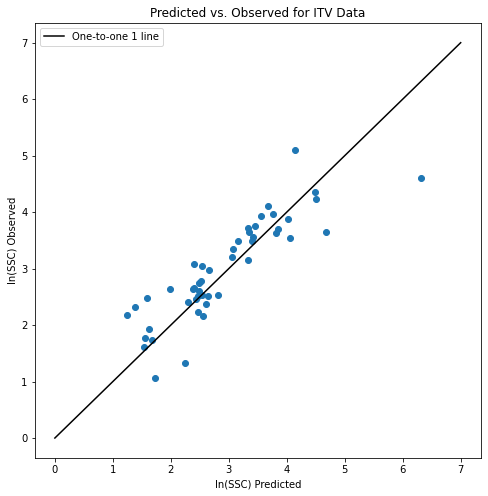

In [5]:
# Plot observed vs predicted for ITV data
plot_obs_predict(
    model_out["itv_obs_predict"],
    title="Predicted vs. Observed for ITV Data",
    savefig=False)

In [6]:
print(model_out["train_R2"])
print(model_out["val_R2"])
print(model_out["itv_R2"])

0.8461459131276693
0.8038998348679738
0.7466270803679074
